In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import collections
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import metrics
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Data

In [2]:
wordnet_lemmatizer = WordNetLemmatizer()
en_stops = set(stopwords.words('english'))
good_stops = ["n't", "not", "no"]

In [4]:
data_air = pd.read_csv('Tweets.csv')
data_air.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
data = data_air.copy()
data['text']=data.text.str.replace('@\w+', '')
data['text']=data['text'].apply(lambda x: emoji.demojize(x))
data['text']=data['text'].apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
data['text']=data.text.str.split()
data['text']=data['text'].apply(lambda x: [wordnet_lemmatizer.lemmatize(item, pos="v") for item in x ])
data['text']=data['text'].apply(lambda x: [item for item in x if item not in en_stops or item in good_stops])
data['text']=data.text.str.join(' ').str.lower().str.replace('http\S+|www.\S+', '', case=False).str.replace('\d+', '')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,what say,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus youve add commercials experience tacky,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,i didnt today must mean i need take another trip,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,really aggressive blast obnoxious entertainmen...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,really big bad thing,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


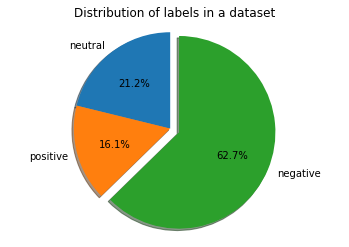

In [8]:
target_cnt = Counter(data.airline_sentiment)

labels = target_cnt.keys()
sizes = target_cnt.values()
explode = (0, 0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Distribution of labels in a dataset')
plt.show()

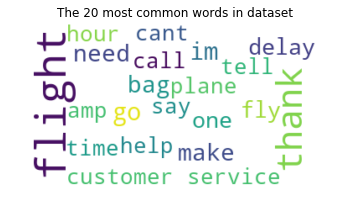

In [10]:
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(data['text'].to_string())
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('The 20 most common words in dataset')
plt.show()

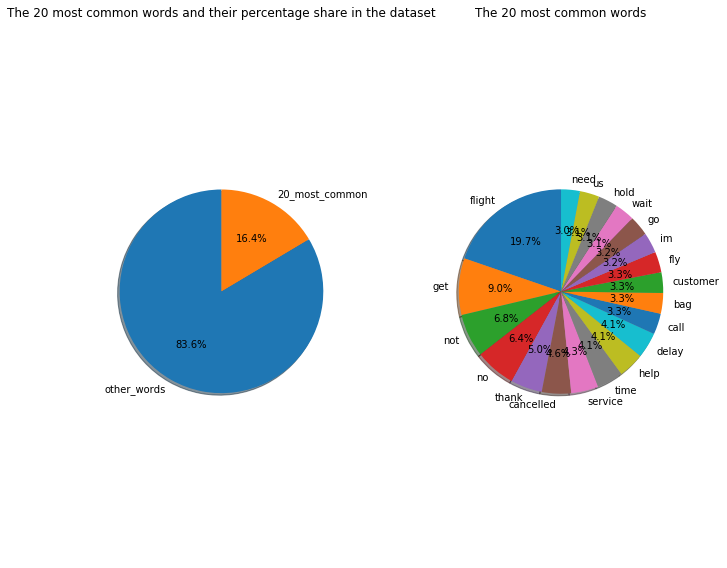

In [12]:
vectorizer = CountVectorizer()
count_data = vectorizer.fit_transform(data.text)

word_freq = dict(zip(vectorizer.get_feature_names(), np.asarray(count_data.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
most_freq = sum(word_counter_df.freq)
all_words = sum(word_counter.values())
others = all_words - most_freq
twenty_all_df = pd.DataFrame({'col1':['other_words', '20_most_common'], 'col2':[others, most_freq]})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
axes[0].pie(twenty_all_df.col2, labels=twenty_all_df.col1, autopct='%1.1f%%',
        shadow=True, startangle=90)
axes[0].axis('equal') 
axes[0].set_title('The 20 most common words and their percentage share in the dataset')

axes[1].pie(word_counter_df.freq, labels=word_counter_df.word, autopct='%1.1f%%',
        shadow=True, startangle=90)
axes[1].axis('equal') 
axes[1].set_title('The 20 most common words')

fig.tight_layout()
plt.show()

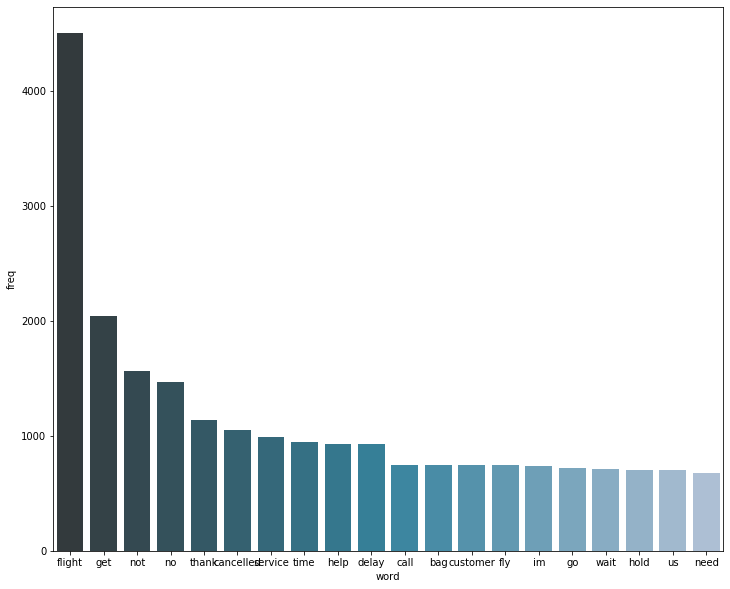

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

# Decission trees

In [29]:
def nothing():
    return no_pp_data_air.text

def no_emoji():
      no_pp_data_air.text = no_pp_data_air.text.apply(lambda x: emoji.demojize(x))

def remove_handle():
    no_pp_data_air.text=no_pp_data_air.text.str.replace('@\w+', '')
    
def remove_punctuation():
    no_pp_data_air.text=no_pp_data_air.text.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))

def lemmatize():
    no_pp_data_air.text=no_pp_data_air.text.str.split()
    no_pp_data_air.text=no_pp_data_air.text.apply(lambda x: [wordnet_lemmatizer.lemmatize(item, pos="v") for item in x ])
    no_pp_data_air.text=no_pp_data_air.text.str.join(' ')

def remove_stop_word():
    no_pp_data_air.text=no_pp_data_air.text.str.split()
    no_pp_data_air.text=no_pp_data_air.text.apply(lambda x: [item for item in x if item not in en_stops or item in good_stops])
    no_pp_data_air.text=no_pp_data_air.text.str.join(' ')

def remove_links_and_number():
    no_pp_data_air.text=no_pp_data_air.text.str.lower().str.replace('http\S+|www.\S+', '', case=False).str.replace('\d+', '')

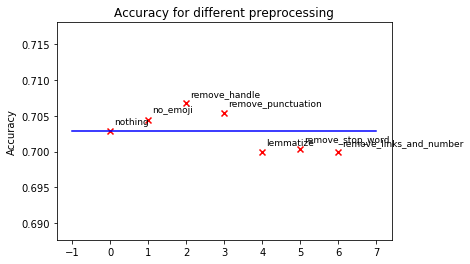

In [39]:
funs = [nothing, no_emoji, remove_handle, remove_punctuation, lemmatize, remove_stop_word, remove_links_and_number]
acc= []
name_fun = []
for fun in funs:
    no_pp_data_air = data_air.copy()
    fun()
    train, test = train_test_split(no_pp_data_air, test_size=0.3, random_state=42)
    X_train = train['text']
    y_train = train['airline_sentiment']

    X_test = test['text']
    y_test = test['airline_sentiment']
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    tee = tree.DecisionTreeClassifier()
    tee = tee.fit(X_train, y_train)
    acc.append(tee.score(X_test, y_test))
    name_fun.append(fun.__name__)
               
for i in range(len(acc)):
    x = i
    y = acc[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.1, y+0.001, name_fun[i], fontsize=9)
plt.plot([-1, 7], [acc[0], acc[0]], color = 'blue')
plt.ylabel('Accuracy')
plt.title('Accuracy for different preprocessing')
plt.show() 

In [45]:
data = data_air.copy()
data['text']=data.text.str.replace('@\w+', '')
data['text']=data['text'].apply(lambda x: emoji.demojize(x))
data['text']=data['text'].apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
data['text']=data.text.str.split()
data['text']=data['text'].apply(lambda x: [wordnet_lemmatizer.lemmatize(item, pos="v") for item in x ])
data['text']=data['text'].apply(lambda x: [item for item in x if item not in en_stops or item in good_stops])
data['text']=data.text.str.join(' ')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,What say,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus youve add commercials experience tacky,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,I didnt today Must mean I need take another trip,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,really aggressive blast obnoxious entertainmen...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,really big bad thing,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [64]:
atrain, atest = train_test_split(data, test_size=0.3, random_state=42)
X_train = atrain['text']
y_train = atrain['airline_sentiment']
X_test = atest['text']
y_test = atest['airline_sentiment']
vectorizer = CountVectorizer(max_df = 0.5, min_df = 1, ngram_range = (1, 2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
tee = tree.DecisionTreeClassifier()
tee = tee.fit(X_train, y_train)
tee.score(X_test, y_test)

0.7449908925318761

In [47]:
def test_all_trees(X, y, X_test, y_test, max_depth=None):
    t = tree.DecisionTreeClassifier(max_depth=max_depth)
    t.fit(X, y)
    print('score: gini', t.score(X_test, y_test))
    labels = t.predict(X_test)
    print(confusion_matrix(y_test, labels))
    
    t_ent = tree.DecisionTreeClassifier(criterion='entropy')
    t_ent.fit(X, y)
    print('score: entropy', t_ent.score(X_test, y_test))
    labels = t_ent.predict(X_test)
    print(confusion_matrix(y_test, labels))
  
    rf = RandomForestClassifier(max_depth=max_depth)
    rf.fit(X, y)
    print('score: Random Forest', rf.score(X_test, y_test))
    labels = rf.predict(X_test)
    print(confusion_matrix(y_test, labels))

    etc = ExtraTreesClassifier(max_depth=max_depth)
    etc.fit(X, y)
    print('score: extremely random', etc.score(X_test, y_test))
    labels = etc.predict(X_test)
    print(confusion_matrix(y_test, labels))   

In [48]:
test_all_trees(X_train, y_train, X_test, y_test)

score: gini 0.7427140255009107
[[2393  282  139]
 [ 338  451   95]
 [ 167  109  418]]
score: entropy 0.7420309653916212
[[2352  321  141]
 [ 307  472  105]
 [ 159  100  435]]


C:\Users\katar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


score: Random Forest 0.7670765027322405
[[2544  209   61]
 [ 390  440   54]
 [ 214   95  385]]


C:\Users\katar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


score: extremely random 0.7739071038251366
[[2555  199   60]
 [ 364  461   59]
 [ 214   97  383]]


C:\Users\katar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Score:  0.7741347905282332


Text(0.5, 257.44, 'Predicted label')

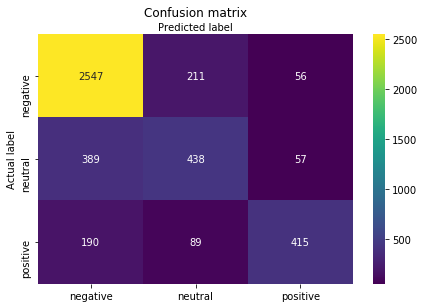

In [51]:
tee = ExtraTreesClassifier()
tee = tee.fit(X_train, y_train)
print('Score: ', tee.score(X_test, y_test))
pred = tee.predict(X_test)
conf_matrix  = confusion_matrix(y_test, pred)
class_names = ['negative','neutral', 'positive']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks([1, 0, 2], class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

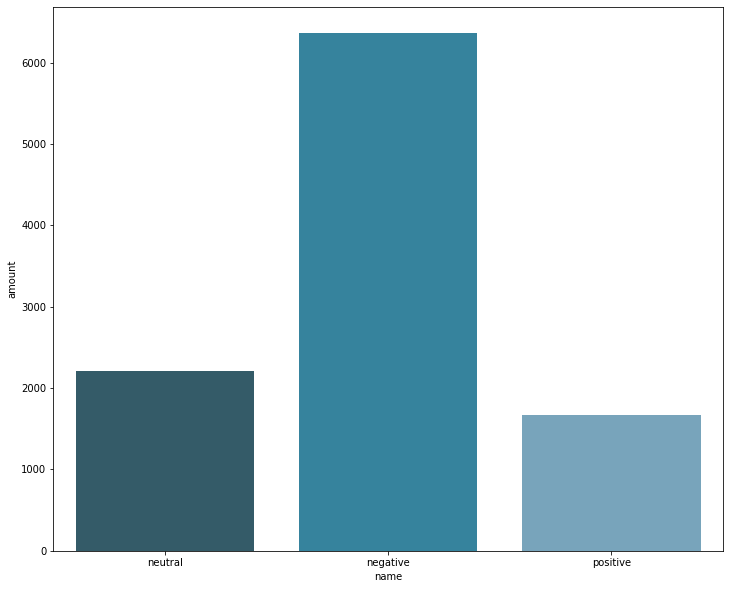

In [66]:
neutral_amount = np.sum([atrain['airline_sentiment']=='neutral'])
negative_amount = np.sum([atrain['airline_sentiment']=='negative'])
positive_amount = np.sum([atrain['airline_sentiment']=='positive'])
amount = pd.DataFrame({'name':['neutral', 'negative', 'positive'], 'amount':[neutral_amount, negative_amount, positive_amount]})
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="name", y="amount", data=amount, palette="PuBuGn_d", ax=ax)
plt.show();

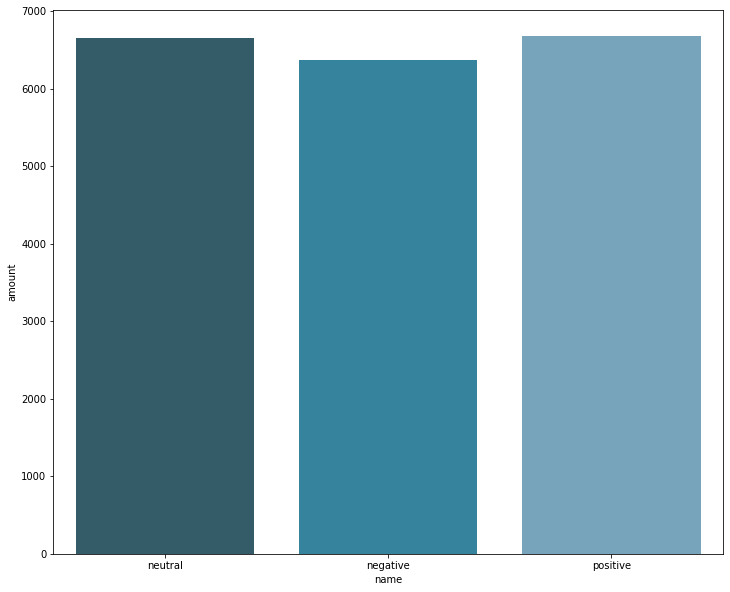

In [67]:
new_neutral=atrain[atrain['airline_sentiment']=='neutral']
new_pos=atrain[atrain['airline_sentiment']=='positive']
atrain = pd.concat([atrain, new_neutral, new_neutral, new_pos, new_pos, new_pos], ignore_index=True, sort=False)
neutral_amount = np.sum([atrain['airline_sentiment']=='neutral'])
negative_amount = np.sum([atrain['airline_sentiment']=='negative'])
positive_amount = np.sum([atrain['airline_sentiment']=='positive'])
amount = pd.DataFrame({'name':['neutral', 'negative', 'positive'], 'amount':[neutral_amount, negative_amount, positive_amount]})
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="name", y="amount", data=amount, palette="PuBuGn_d", ax=ax)
plt.show();

C:\Users\katar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Score:  0.7741347905282332


Text(0.5, 257.44, 'Predicted label')

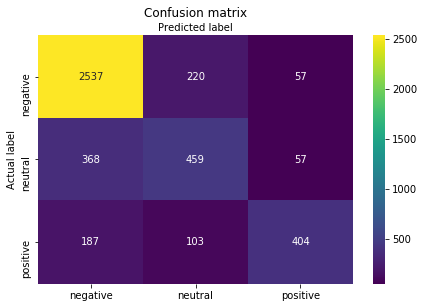

In [54]:
X_train = atrain['text']
y_train = atrain['airline_sentiment']
X_test = atest['text']
y_test = atest['airline_sentiment']
vectorizer = CountVectorizer(max_df = 0.5, min_df = 1, ngram_range = (1, 2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
tee = ExtraTreesClassifier()
tee = tee.fit(X_train, y_train)
print('Score: ', tee.score(X_test, y_test))
pred = tee.predict(X_test)
conf_matrix  = confusion_matrix(y_test, pred)
class_names = ['negative','neutral', 'positive']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks([1, 0, 2], class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Logistic regression

C:\Users\katar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\katar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


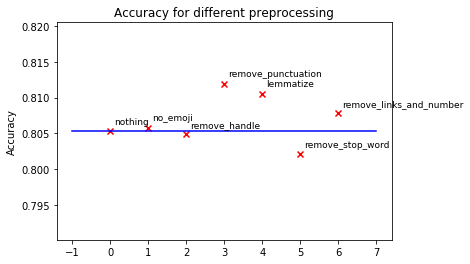

In [68]:
funs = [nothing, no_emoji, remove_handle, remove_punctuation, lemmatize, remove_stop_word, remove_links_and_number]
acc= []
name_fun = []
for fun in funs:
    no_pp_data_air = data_air.copy()
    fun()
    train, test = train_test_split(no_pp_data_air, test_size=0.3, random_state=42)
    X_train = train['text']
    y_train = train['airline_sentiment']

    X_test = test['text']
    y_test = test['airline_sentiment']
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    acc.append(lr.score(X_test, y_test))
    name_fun.append(fun.__name__)
               
for i in range(len(acc)):
    x = i
    y = acc[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.1, y+0.001, name_fun[i], fontsize=9)
plt.plot([-1, 7], [acc[0], acc[0]], color = 'blue')
plt.ylabel('Accuracy')
plt.title('Accuracy for different preprocessing')
plt.show() 

In [69]:
data = data_air.copy()
data['text']=data.text.str.replace('@\w+', '')
data['text']=data['text'].apply(lambda x: emoji.demojize(x))
data['text']=data['text'].apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
data['text']=data.text.str.split()
data['text']=data['text'].apply(lambda x: [wordnet_lemmatizer.lemmatize(item, pos="v") for item in x ])
data['text']=data.text.str.join(' ').str.lower().str.replace('http\S+|www.\S+', '', case=False).str.replace('\d+', '')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,what say,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus youve add commercials to the experience t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,i didnt today must mean i need to take another...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,its really aggressive to blast obnoxious enter...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,and its a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [70]:
atrain, atest = train_test_split(data, test_size=0.3, random_state=42)
X_train = atrain['text']
y_train = atrain['airline_sentiment']
X_test = atest['text']
y_test = atest['airline_sentiment']
vectorizer = CountVectorizer(max_df = 0.5, min_df = 1, ngram_range = (1, 2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8128415300546448

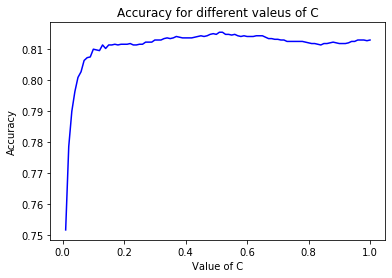

In [73]:
cs = np.arange(0.01, 1.01, 0.01)
acc= []
best_acc, best_c = 0, 0
for c in cs:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    score = lr.score(X_test, y_test)
    acc.append(score)
    if score > best_acc:
        best_acc = score
        best_c = c
               
plt.plot(cs, acc, color = 'blue')
plt.ylabel('Accuracy')
plt.xlabel('Value of C')
plt.title('Accuracy for different valeus of C')
plt.show() 

In [74]:
best_c

0.51

Score:  0.8153460837887068


Text(0.5, 257.44, 'Predicted label')

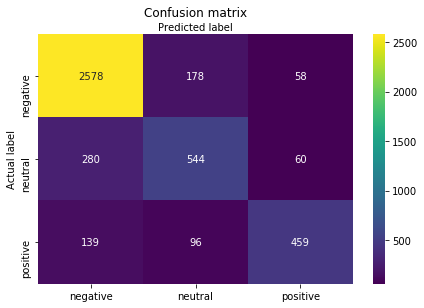

In [76]:
lr = LogisticRegression(C=best_c)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print('Score: ', lr.score(X_test, y_test))
conf_matrix  = confusion_matrix(y_test, pred)
class_names = ['negative','neutral', 'positive']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks([1, 0, 2], class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

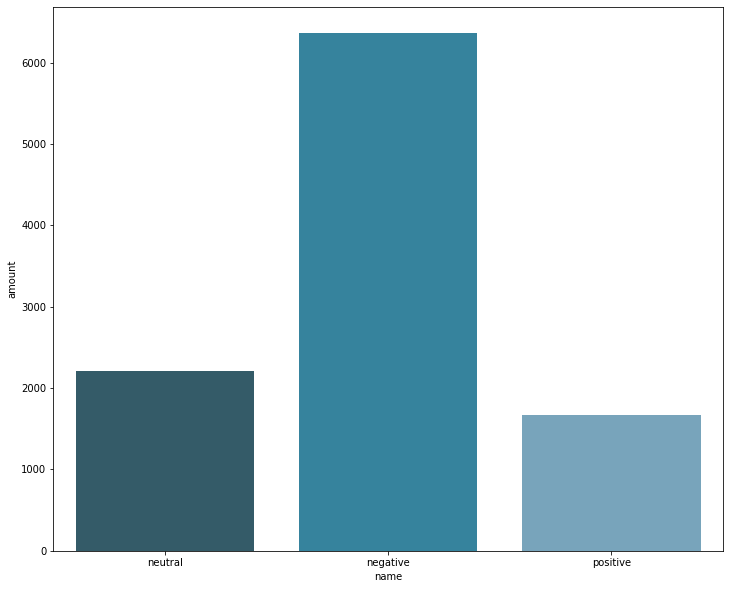

In [77]:
neutral_amount = np.sum([atrain['airline_sentiment']=='neutral'])
negative_amount = np.sum([atrain['airline_sentiment']=='negative'])
positive_amount = np.sum([atrain['airline_sentiment']=='positive'])
amount = pd.DataFrame({'name':['neutral', 'negative', 'positive'], 'amount':[neutral_amount, negative_amount, positive_amount]})
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="name", y="amount", data=amount, palette="PuBuGn_d", ax=ax)
plt.show();

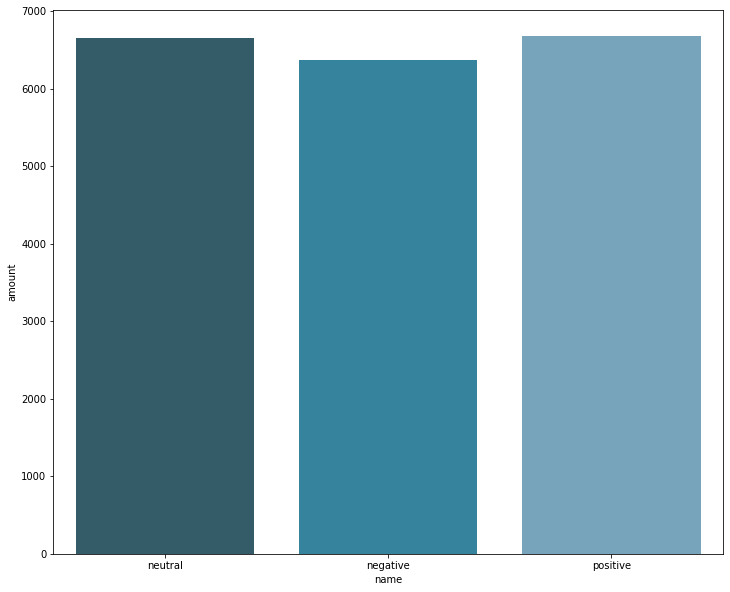

In [78]:
new_neutral=atrain[atrain['airline_sentiment']=='neutral']
new_pos=atrain[atrain['airline_sentiment']=='positive']
atrain = pd.concat([atrain, new_neutral, new_neutral, new_pos, new_pos, new_pos], ignore_index=True, sort=False)
neutral_amount = np.sum([atrain['airline_sentiment']=='neutral'])
negative_amount = np.sum([atrain['airline_sentiment']=='negative'])
positive_amount = np.sum([atrain['airline_sentiment']=='positive'])
amount = pd.DataFrame({'name':['neutral', 'negative', 'positive'], 'amount':[neutral_amount, negative_amount, positive_amount]})
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="name", y="amount", data=amount, palette="PuBuGn_d", ax=ax)
plt.show();

Score:  0.8028233151183971


Text(0.5, 257.44, 'Predicted label')

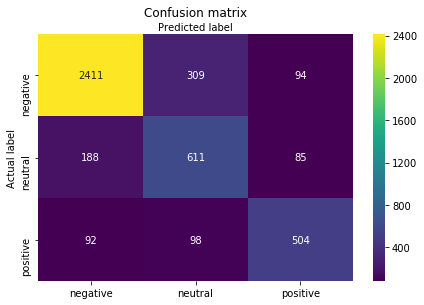

In [79]:
X_train = atrain['text']
y_train = atrain['airline_sentiment']
X_test = atest['text']
y_test = atest['airline_sentiment']
vectorizer = CountVectorizer(max_df = 0.5, min_df = 1, ngram_range = (1, 2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
lr = LogisticRegression(C=best_c)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print('Score: ', lr.score(X_test, y_test))
conf_matrix  = confusion_matrix(y_test, pred)
class_names = ['negative','neutral', 'positive']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks([1, 0, 2], class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')